In this series, I want to discuss the creation of a small library for training neural networks: `nntrain`. It's based off the excellent [part 2](https://course.fast.ai/) of Practical Deep Learning for Coders by Jeremy Howard, in which from lessons 13 to 18 (roughly) the development of the `miniai` library is discussed.

The library will build upon PyTorch. We'll try as much as possible to build from scratch to understand how it all works. Once the main functionality of components are implemented and verified, we can switch over to PyTorch's version. This is similar to how things are done in the course. However, this is not just a "copy / paste" of the course: on many occasions I take a different route, and most of the code is my own. That is not to say that all of this is meant to be extremely innovative, instead I had the following goals:

- Deeply understand the training of neural networks with a focus on PyTorch
- Try to create an even better narrative then what's presented in FastAI 🙉🤷‍♂️🙈
- Get hands-on experience with creating a library with [`nb_dev`](https://nbdev.fast.ai/)

`nb_dev` is another great project from the fastai community, which allows python libraries to be written in jupyter notebooks. This may sound a bit weird since the mainstream paradigm is to only do experimental work in notebooks. It has the advantage though that we can create the source code for our library in the very same environment in which we want to experiment and interact with our methods, objects and structure **while we are building the library**. For more details on why this is a good idea and other nice features of `nb_dev`, see [here](https://www.fast.ai/posts/2022-07-28-nbdev2.html).

So without further ado, let's start with where we left off in the previous [post](https://lucasvw.github.io/posts/08_nntrain_setup/):

## End of last post:

We finished the last post with exporting the `dataloaders` module into the `nntrain` library, which helps transforming a huggingface dataset dictionary into PyTorch dataloaders, so let's use [that](https://lucasvw.github.io/nntrain/dataloaders.html):

In [ ]:
from datasets import load_dataset,load_dataset_builder

from nntrain.dataloaders import DataLoaders, hf_ds_collate_fn

In [ ]:
 #| export
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
import torch.nn.functional as F
from operator import attrgetter
import fastcore.all as fc
import math

In [ ]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
hf_dd = load_dataset(name)

bs = 1024
dls = DataLoaders.from_hf_dd(hf_dd, batch_size=bs)

# As a reminder, `DataLoaders` expose a PyTorch train and validation dataloader as `train` and `valid` attributes:

dls.train, dls.valid

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

(<torch.utils.data.dataloader.DataLoader>,
 <torch.utils.data.dataloader.DataLoader>)

## Learner Class

Let's continue to formalize our training loop into a `Learner` class with a `fit()` method. So far the training loop looks like:

```{.python code-line-numbers='true'}
def fit(epochs):
    for epoch in range(epochs):
        model.train()                                       
        n_t = train_loss_s = 0                              
        for xb, yb in dls.train:
            preds = model(xb)
            train_loss = loss_func(preds, yb)
            train_loss.backward()
            
            n_t += len(xb)
            train_loss_s += train_loss.item() * len(xb)
            
            opt.step()
            opt.zero_grad()
        
        model.eval()                                        
        n_v = valid_loss_s = acc_s = 0                      
        for xb, yb in dls.valid: 
            with torch.no_grad():                           
                preds = model(xb)
                valid_loss = loss_func(preds, yb)
                
                n_v += len(xb)
                valid_loss_s += valid_loss.item() * len(xb)
                acc_s += accuracy(preds, yb) * len(xb)
        
        train_loss = train_loss_s / n_t                     
        valid_loss = valid_loss_s / n_v
        acc = acc_s / n_v
        print(f'{epoch=} | {train_loss=:.3f} | {valid_loss=:.3f} | {acc=:.3f}')
```

Let's build this class in steps. Initialization is straigh forward: pass in everything the class needs to have access to. Note that we pass the optimizer class in, and instantiate it during initialization to be able to pass the model parameters and the learning rate.

In [ ]:
class Learner():
    def __init__(self, model, dls, loss_fn, metric_fn, optim_class, lr):
        self.model = model
        self.dls = dls
        self.loss_fn = loss_fn
        self.metric_fn = metric_fn
        self.optim = optim_class(model.parameters(), lr)

Next, let's define the outer most call: `fit()`. The main improvement here is to call `one_epoch` twice, once for the training and once for the validation. Both passes are fairly similar as can be seen from comparing lines 3-8 with 16-21

In [ ]:
@fc.patch
def fit(self:Learner, epochs):
    for epoch in range(epochs):                # iterate through the epochs
        self.one_epoch(epoch, train=True)      # one epoch through the training dataloader
        with torch.no_grad():                  # for the validation epoch we don't need grads
            self.one_epoch(epoch, train=False) # one epoch through the validation dataloader

Next, let's implement `one_epoch()`. To keep the functionality nice and small, we factor `do_batch()` out into it's own method

In [ ]:
@fc.patch
def one_epoch(self:Learner, epoch, train):
    self.reset_stats()                         # reset the stats at beginning of each epoch
    self.model.train(train)                    # put the model either in train or validation mode
    self.dl = self.dls.train if train else self.dls.valid # reference to the active dataloader
    for self.batch in self.dl:                 # iterate through the active dataloader
        self.one_batch(train)                  # do one batch
    self.print_stats(epoch, train)             # print stats at the end of the epoch

And finally the method responsible for dealing with a single batch of data:

In [ ]:
@fc.patch
def one_batch(self:Learner, train):
    self.xb, self.yb = self.batch
    self.preds = self.model(self.xb)           # forward pass through the model
    self.loss = self.loss_fn(self.preds, self.yb)  # loss
    if train:                                  # only do a backward and weight update if train
        self.loss.backward()
        self.optim.step()
        self.optim.zero_grad()
    self.update_stats()                        # update stats

We also add the methods related to the computation of the statistics:

In [ ]:
@fc.patch
def update_stats(self:Learner):
    n = len(self.xb)
    self.loss_s += self.loss.item() * n
    self.metric_s += self.metric_fn(self.preds, self.yb).item() * n
    self.counter += n

@fc.patch
def reset_stats(self:Learner):
    self.counter = 0
    self.loss_s = 0
    self.metric_s = 0

@fc.patch
def print_stats(self:Learner, epoch, train):
    loss = self.loss_s / self.counter
    metric = self.metric_s / self.counter
    print(f'{epoch=:02d} | {"train" if train else "eval":<5} | {loss=:.3f} | {metric=:.3f}')

And let's do a round of training:

In [ ]:
n_in = 28*28
n_h = 50
n_out = 10
lr = 0.01

def accuracy(preds, targs):
    return (preds.argmax(dim=1) == targs).float().mean()

def get_model():
    layers = [nn.Linear(n_in, n_h), nn.ReLU(), nn.Linear(n_h, n_out)]
    return nn.Sequential(*layers)

l = Learner(get_model(), dls, F.cross_entropy, accuracy, torch.optim.SGD, lr)

l.fit(5)

epoch=00 | train | loss=2.177 | metric=0.238
epoch=00 | eval  | loss=2.056 | metric=0.366
epoch=01 | train | loss=1.925 | metric=0.449
epoch=01 | eval  | loss=1.788 | metric=0.526
epoch=02 | train | loss=1.654 | metric=0.601
epoch=02 | eval  | loss=1.529 | metric=0.640
epoch=03 | train | loss=1.421 | metric=0.659
epoch=03 | eval  | loss=1.329 | metric=0.654
epoch=04 | train | loss=1.249 | metric=0.667
epoch=04 | eval  | loss=1.187 | metric=0.658


## Callbacks, pubsub and event handlers

On the one side we want to keep the `Learner` and its training loop generic on the other side we need to be able to tweak the dynamics of the training loop depending on the use-case. One way to customize the training loop, without having to re-write the training loop would be to add a publish/subscribe (pubsub) mechanism. In the FastAI course, they are referred to as "callbacks", and although callbacks, event handlers and pubsub are all related. I think the mechanism implemented here is best referred to as pubsub. It can be compared to the way front-end development works. Whenever the user takes an action such as clicking a button, or hovering over a button certain events are **published**. The developer can **subscribe** to these events by adding a function (a **callback** or **event handler**) that get's called whenever they occur.

For the purposes of training neural networks we have the following requirements:

- The Learner framework defines a number of "events" that are published:
  - `before_fit`, `after_fit`
  - `before_epoch`, `after_epoch`
  - `before_batch`, `after_batch`
- Subscribers are classes that implement methods (e.g. `before_fit()`) that will be triggered whenever the associated event is published. They also have an `order` attribute which determines the order in which they are called in case multiple Subscribers subscribed to the same event.
- As an additional feature, subscribers will be able to redirect flow, but we will come back to that later

So let's implement this. First, we will need to store subscribers in the Learner class:

In [ ]:
class Learner():
    def __init__(self, model, dls, loss_fn, metric_fn, optim_class, lr, subs):
        self.model = model
        self.dls = dls
        self.loss_fn = loss_fn
        self.metric_fn = metric_fn
        self.optim = optim(model.parameters(), lr)
        self.subs = subs

Next, let's define a method for publishing events. The method will go through the registered subscribers and if a method with the name of the event is declared, call that method passing the `learner` object as an argument:

In [ ]:
@fc.patch
def publish(self:Learner, event):
    for sub in sorted(self.subs, key=attrgetter('order')):
        method = getattr(sub, name, None)
        if method is not None: method(self)

To publish the events during the training loop, realize that we have three time the same construct:

```
publish "before_event" event
do event
publish "after_event" event
```

With `event` being either `fit`, `epoch` or `batch`. So instead of adding this construct multiple times in the training loop let's define a class we can use as a decorater wrapping the actual "event":

In [ ]:
 #| export

class PublishEvents():
    def __init__(self, event): 
        self.event = event
    
    def __call__(self, decorated_fn):
        def decorated_fn_with_publishing(learner, *args, **kwargs):
            learner.publish(f'before_{self.event}')
            decorated_fn(learner, *args, **kwargs)
            learner.publish(f'after_{self.event}')
        return decorated_fn_with_publishing

To implement this into the `Learner` we have to factor out the exact code we want to be executed in between the publishing of the `before` and `after`, see the additional `_one_epoch()` method:

In [ ]:
 #| export
class Learner():
    def __init__(self, model, dls, loss_fn, metric_fn, optim_class, lr, subs):
        self.model = model
        self.dls = dls
        self.loss_fn = loss_fn
        self.metric_fn = metric_fn
        self.optim = optim_class(model.parameters(), lr)
        self.subs = subs
    
    @PublishEvents('fit')
    def fit(self, epochs):
        for epoch in range(epochs):
            self.one_epoch(epoch, train=True)
            with torch.no_grad():
                self.one_epoch(epoch, train=False)

    def one_epoch(self, epoch, train):
        self.reset_stats()
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        self._one_epoch(epoch, train)
        
    @PublishEvents('epoch')
    def _one_epoch(self, epoch, train):
        for self.batch in self.dl:
            self.xb, self.yb = self.batch
            self.one_batch(train)
        self.print_stats(epoch, train)
    
    @PublishEvents('batch')
    def one_batch(self, train):
        self.preds = self.model(self.xb)           
        self.loss = self.loss_fn(self.preds, self.yb)
        if train:                                  
            self.loss.backward()
            self.optim.step()
            self.optim.zero_grad()
        self.update_stats()
        
    def publish(self, event):
        for sub in sorted(self.subs, key=attrgetter('order')):
            method = getattr(sub, event, None)
            if method is not None: method(self)
            
    def update_stats(self):
        n = len(self.xb)
        self.loss_s += self.loss.detach().cpu().item() * n
        self.metric_s += self.metric_fn(self.preds, self.yb).detach().cpu().item() * n
        self.counter += n

    def reset_stats(self):
        self.counter = 0
        self.loss_s = 0
        self.metric_s = 0

    def print_stats(self, epoch, train):
        loss = self.loss_s / self.counter
        metric = self.metric_s / self.counter
        print(f'{epoch=:02d} | {"train" if train else "eval":<5} | {loss=:.3f} | {metric=:.3f}')

Let's create a dummy subscriber and test it out:

In [ ]:
class Subscriber():
    order = 0

class DummySub(Subscriber):
    
    def before_fit(self, learn):
        print('before fit👋')
        
    def after_fit(self, learn):
        print('after fit👋')
        
    def before_epoch(self, learn):
        print('before epoch 💥')
        
    def after_epoch(self, learn):
        print('after epoch 💥')

In [ ]:
l = Learner(model, dls, F.cross_entropy, accuracy, torch.optim.SGD, lr, [DummySub()])
l.fit(1)

before fit👋
before epoch 💥
epoch=00 | train | loss=1.126 | metric=0.670
after epoch 💥
before epoch 💥
epoch=00 | eval  | loss=1.086 | metric=0.662
after epoch 💥
after fit👋


## Subscribers can cancel execution

Now let's add the last component of our pubsub system: subscribers should be able to cancel processing. For example, a a subscriber that would implement Early Stopping, will have to be able to cancel any further epochs when the validation loss starts increasing. One way to implement this, is with the help of `Exceptions` and `try` / `except` blocks:

It's actually very easy to implement this logic, we only need to define custom `Exceptions`, and update the `PublishEvents` class we are using as decorater to catch the exceptions that are thrown in any subscriber:

In [ ]:
class CancelFitException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass


class PublishEvents():
    def __init__(self, name): 
        self.name = name
    
    def __call__(self, decorated_fn):
        def decorated_fn_with_publishing(learner, *args, **kwargs):
            try:
                learner.publish(f'before_{self.name}')
                decorated_fn(learner, *args, **kwargs)
                learner.publish(f'after_{self.name}')
            except globals()[f'Cancel{self.name.title()}Exception']: pass
        return decorated_fn_with_publishing

In [ ]:
class DummySub(Subscriber):
    
    def before_fit(self, learn): print('before fit👋')
        
    def before_epoch(self, learn): raise CancelFitException
    
    def after_fit(self, learn): print('after fit 👋')

In [ ]:
l = Learner(model, dls, F.cross_entropy, accuracy, torch.optim.SGD, lr, [DummySub()])
l.fit(5)

before fit👋


And indeed, the `after_fit` event is never published, since the fit was cancelled during `before_epoch`

## Final version of `Learner`

We are going to make some final changes to the Learner class:

- remove all the methods related to metrics and statistics, since we will do that in a Subscriber
- factor out the computation of the following logic. This is practical to create subclasses of `Learner` with custom behavior:
  - prediction: `self.predict()`
  - loss: `self.get_loss()`
  - backward pass: `self.backward()`
  - stepping of weights: `self.step()`
  - zeroing of gradients: `self.zero_grad()`
- add a Subscriber argument to `fit`, these subs will only be added for the duration of the fit, and afterwards removed
- add a couple of additional events (`after_predict`, `after_loss`, `after_backward` and `after_step`) to which subscribers can listen

In [ ]:
 #| export
class Learner():
    def __init__(self, model, dls, loss_fn, optim_class, lr, subs):
        self.model = model
        self.dls = dls
        self.loss_fn = loss_fn
        self.optim_class = optim_class
        self.lr = lr
        self.subs = subs
    
    def fit(self, epochs, train=True, valid=True, subs=[], lr=None):
        for sub in subs: self.subs.append(sub)
        self.n_epochs = epochs
        self.epochs = range(self.n_epochs)
        lr = self.lr if lr is None else lr
        self.opt = self.optim_class(self.model.parameters(), lr)
        try:
            self._fit(train, valid)
        finally:
            for sub in subs: self.subs.remove(sub)
                    
    @PublishEvents('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train: 
                self.one_epoch(True)
            if valid:
                with torch.no_grad():
                    self.one_epoch(False)
        
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        self._one_epoch()
        
    @PublishEvents('epoch')
    def _one_epoch(self):
        for self.batch in self.dl: 
            self.one_batch()
    
    @PublishEvents('batch')
    def one_batch(self):
        self.predict()
        self.publish('after_predict')
        self.get_loss()
        self.publish('after_loss')
        if self.model.training:
            self.backward()
            self.publish('after_backward')
            self.step()
            self.publish('after_step')
            self.zero_grad()
        
    def publish(self, event):
        for sub in sorted(self.subs, key=attrgetter('order')):
            method = getattr(sub, event, None)
            if method is not None: method(self)
            
    def predict(self): 
        self.preds = self.model(self.batch[0])
        
    def get_loss(self): 
        self.loss = self.loss_fn(self.preds, self.batch[1])
        
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

## Metrics Subscriber

Since we took out the metrics, let's create a subscriber that adds that. We want the subscriber to be generic, to it should be able to accept one or multiple metrics. Let's make sure that it can accept the metrics from the `torcheval` library:

In [ ]:
 #|export
import torcheval.metrics as tem

In [ ]:
metric = tem.Mean()

metric.update(torch.tensor([1,2,3]))  # update() adds data
metric.update(torch.tensor([4,5,6]))  
print(metric.compute())               # compute() computes the metric

metric.reset()
print(metric.compute())

tensor(3.5000, dtype=torch.float64)
tensor(0., dtype=torch.float64)


In [ ]:
 #|export
class MetricsSub(Subscriber):
    def __init__(self, **metrics):
        self.metrics = metrics
        self.loss = tem.Mean()
        
    def before_fit(self, learn): 
        learn.metrics = self
    
    def before_epoch(self, learn):
        for m in self.metrics.values(): m.reset()
        self.loss.reset()
    
    def after_batch(self, learn):
        x,y,*_ = self.to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(self.to_cpu(learn.preds), y)
        self.loss.update(self.to_cpu(learn.loss), weight=len(x))
        
    def after_epoch(self, learn):
        log = {
            'epoch': learn.epoch,
            'mode': 'train' if learn.model.training else 'eval',
            'loss' : f'{self.loss.compute():.3f}'
        }
        for k, v in self.metrics.items():
            log[k] = f'{v.compute():.3f}'
        self.output(log)
        
    def to_cpu(self, x):
        if isinstance(x, list): return (self.to_cpu(el) for el in x)
        return x.detach().cpu()
        
    def output(self, log): print(log)

In [ ]:
metrics = MetricsSub(accuracy=tem.MulticlassAccuracy())

In [ ]:
l = Learner(get_model(), dls, F.cross_entropy, torch.optim.SGD, lr, [metrics])
l.fit(1)

{'epoch': 0, 'mode': 'train', 'loss': '2.188', 'accuracy': '0.274'}
{'epoch': 0, 'mode': 'eval', 'loss': '2.075', 'accuracy': '0.367'}


## Device Subscriber

It's time we start training on the GPU, to do that we have to move the model (and it's parameters) as well as all the data onto the GPU. We can easily do this with a `DeviceSub`:

- move the model to the device **before fit**
- move each batch to the device **before batch**

In [ ]:
 #| export

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
class DeviceSub(Subscriber):
    
    def __init__(self, device):
        self.device = device
    
    def before_fit(self, learn):
        learn.model.to(self.device)
    
    def before_batch(self, learn):
        learn.batch = [x.to(self.device) for x in learn.batch]

In [ ]:
l = Learner(get_model(), dls, F.cross_entropy, torch.optim.SGD, lr, [metrics, DeviceSub(device)])
l.fit(1)

{'epoch': 0, 'mode': 'train', 'loss': '2.167', 'accuracy': '0.358'}
{'epoch': 0, 'mode': 'eval', 'loss': '2.034', 'accuracy': '0.444'}


## Learning Rate Finder

The learning rate finder is very simple technique that can be used to find a good learning rate for training your network. It basically starts with a very small learning rate with which just one batch of data is processed. After the batch the loss is recorded. Then, before continuing with the next batch, the learning rate is increased by some constant factor. This process is continued until some criterion is reached, for example the loss has reached a factor of 3 times the smallest value. Then, we plot the learning rates vs the obtained loss's and determine a good learning rate:

In [ ]:
 #| export
class LRFindSub(Subscriber):
    
    def __init__(self, mult=1.25):
        self.mult = mult
        self.min = math.inf
        
    def before_epoch(self, learn):
        if not learn.model.training: raise CancelFitException
        self.losses = []
        self.lrs = []
    
    def after_loss(self, learn):
        lr = learn.opt.param_groups[0]['lr']
        self.lrs.append(lr)
        loss = learn.loss.detach().cpu()
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*3: raise CancelFitException()
        for g in learn.opt.param_groups: g['lr'] = lr * self.mult
        
    def plot(self):
        plt.plot(lrfind.lrs, lrfind.losses)
        plt.xscale('log')

In [ ]:
l = Learner(get_model(), dls, F.cross_entropy, torch.optim.SGD, lr, [metrics, DeviceSub(device)])

In [ ]:
lrfind = LRFindSub()
l.fit(5, subs=[lrfind])

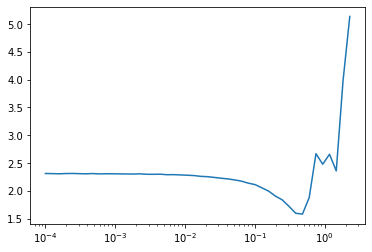

In [ ]:
lrfind.plot()

From which we see that a learning rate of 0.1 to 0.5 would be fine

## MomentumLearner

Additionally, we can create a subclass of `Learner` that implements Momentum. Momentum is a technique that doesn't just use the gradient of the last backward pass, but uses an exponentially weighted average of all previously computed gradients.

In [ ]:
 #| export
class MomentumLearner(Learner):
    
    def __init__(self, model, dls, loss_fn, optim_class, lr, subs, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_fn, optim_class, lr, subs)
        
    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters(): p.grad *= self.mom

In [ ]:
l = MomentumLearner(get_model(), dls, F.cross_entropy, torch.optim.SGD, lr, [metrics, DeviceSub(device)])
l.fit(5)

{'epoch': 0, 'mode': 'train', 'loss': '1.694', 'accuracy': '0.492'}
{'epoch': 0, 'mode': 'eval', 'loss': '1.117', 'accuracy': '0.657'}
{'epoch': 1, 'mode': 'train', 'loss': '0.927', 'accuracy': '0.694'}
{'epoch': 1, 'mode': 'eval', 'loss': '0.826', 'accuracy': '0.711'}
{'epoch': 2, 'mode': 'train', 'loss': '0.756', 'accuracy': '0.742'}
{'epoch': 2, 'mode': 'eval', 'loss': '0.728', 'accuracy': '0.740'}
{'epoch': 3, 'mode': 'train', 'loss': '0.679', 'accuracy': '0.769'}
{'epoch': 3, 'mode': 'eval', 'loss': '0.669', 'accuracy': '0.767'}
{'epoch': 4, 'mode': 'train', 'loss': '0.629', 'accuracy': '0.788'}
{'epoch': 4, 'mode': 'eval', 'loss': '0.630', 'accuracy': '0.783'}


From which we see that the accuracy on the validation set is increasing (even with this simple linear model) from 66% with normal SGD to 78% with momentum.